# CNN_&_RESNET50

## RESNET 50

Deep residual networks like the popular ResNet-50 model is a convolutional neural network (CNN) that is 50 layers deep. A residual neural network (ResNet) is an artificial neural network (ANN) of a kind that stacks residual blocks on top of each other to form a network.



#### What is Deep Residual Learning used for?
ResNet was created with the aim of tackling this exact problem. Deep residual nets make use of residual blocks to improve the accuracy of the models. The concept of “skip connections,” which lies at the core of the residual blocks, is the strength of this type of neural network.



#### What is Skip Function? 
By adding skip connections, you allow gradients to flow easily from layer to layer. This helps to train really deep networks - from the very start, even the lowest layer receives activations from the top layer!

#### Benefits of using Skip Function

1. Over-fitting
2. Exploding and Vanishing Gradients
3. Degradation

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [3]:
dataset_url ='https://www.kaggle.com/tawsifurrahman/covid19-radiography-database'

In [4]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ehtisham49
Your Kaggle Key: ··········


100%|██████████| 745M/745M [00:04<00:00, 195MB/s]


In [5]:
import os 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import cv2

In [6]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 
    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return train_data, val_data

In [7]:
folder_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.


In [8]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

# What is Early Stopping?

Early stopping is a method that allows you to specify an arbitrarily large number of training epochs and stop training once the model performance stops improving on the validation dataset

In [9]:
def cnn_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    i = Input(shape=(size,size,3)) #defining input
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i) #adding convolution layers
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [10]:
epochs = 3
r,model,n_epochs = cnn_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                              

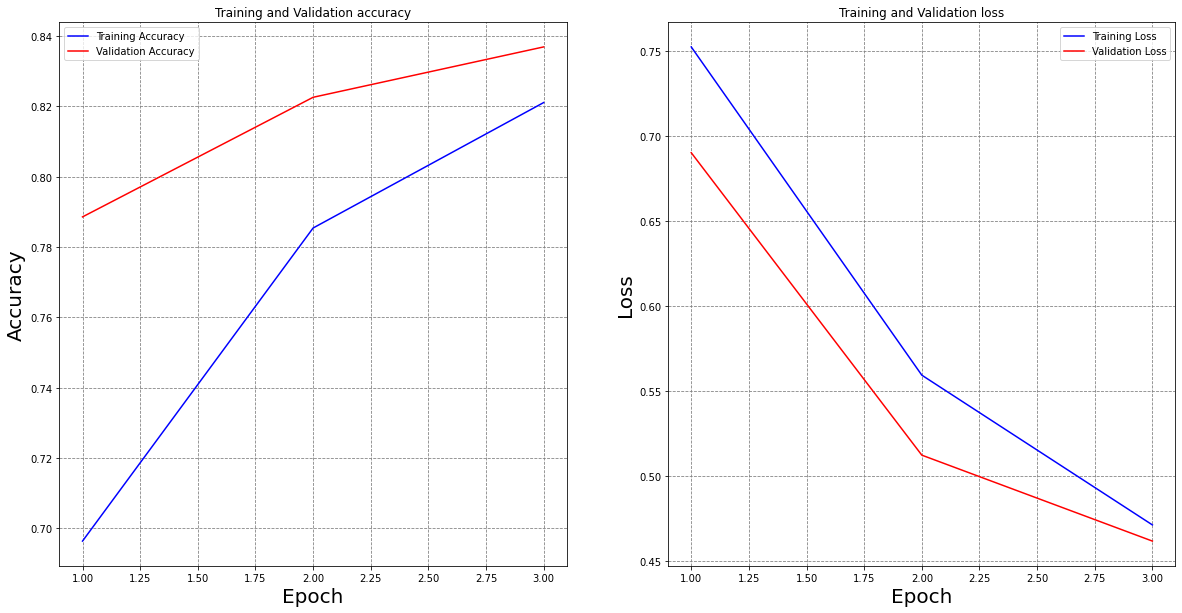

In [11]:
plotLearningCurve(r,n_epochs)

In [12]:
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 60s 299ms/step - loss: 0.4619 - accuracy: 0.8369
Test Accuracy using CNN: 83.69%
464/464 [==============================] - 140s 301ms/step - loss: 0.4449 - accuracy: 0.8413
Train Accuracy using CNN: 84.13%


In [13]:
def resnet_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (size,size,3), include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model=Model(inputs=base_model.input,outputs=out) 
    # model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [14]:
epochs = 3
r,model,n_epochs = resnet_model(train_data, val_data,epochs,128)

----Building the model----
94781440/94765736 [==============================] - 1s 0us/step
----Training the network----
Epoch 1/3

Epoch 00001: val_loss improved from inf to 1.54720, saving model to resnet_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


464/464 - 4152s - loss: 0.3430 - accuracy: 0.8742 - val_loss: 1.5472 - val_accuracy: 0.3602 - 4152s/epoch - 9s/step
Epoch 2/3

Epoch 00002: val_loss improved from 1.54720 to 0.64444, saving model to resnet_model.h5
464/464 - 4123s - loss: 0.1583 - accuracy: 0.9424 - val_loss: 0.6444 - val_accuracy: 0.7934 - 4123s/epoch - 9s/step
Epoch 3/3

Epoch 00003: val_loss improved from 0.64444 to 0.19240, saving model to resnet_model.h5
464/464 - 4166s - loss: 0.0991 - accuracy: 0.9648 - val_loss: 0.1924 - val_accuracy: 0.9365 - 4166s/epoch - 9s/step
464/464 [==============================] - 761s 2s/step - loss: 0.0657 - accuracy: 0.9791
Train score: [0.06566658616065979, 0.9791469573974609]
199/199 [==============================] - 329s 2s/step - loss: 0.1924 - accuracy: 0.9365
Test score: [0.1923968493938446, 0.9365054368972778]


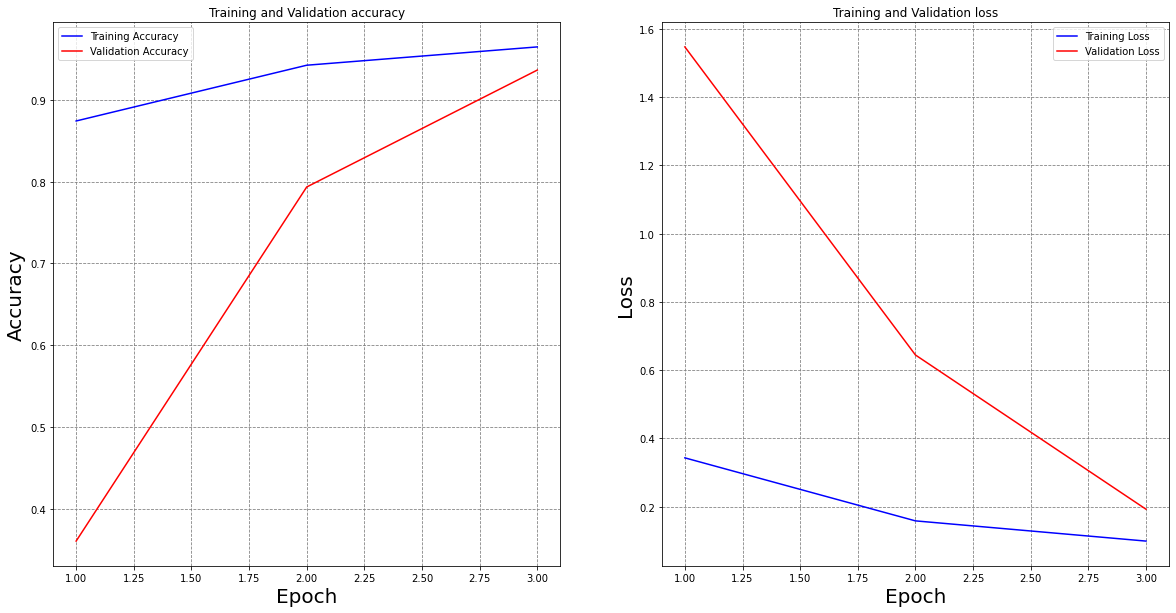

In [15]:
plotLearningCurve(r,n_epochs)

In [16]:
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 325s 2s/step - loss: 0.1924 - accuracy: 0.9365
Test Accuracy using ResNet50: 93.65%
464/464 [==============================] - 762s 2s/step - loss: 0.0657 - accuracy: 0.9791
Train Accuracy using ResNet50: 97.91%
